In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Breast_Cancer.csv to Breast_Cancer.csv


Mejor t0=0.30, t1=0.95, F1-macro=0.8602
Casos confiables: 276 / 805
Casos inciertos: 529


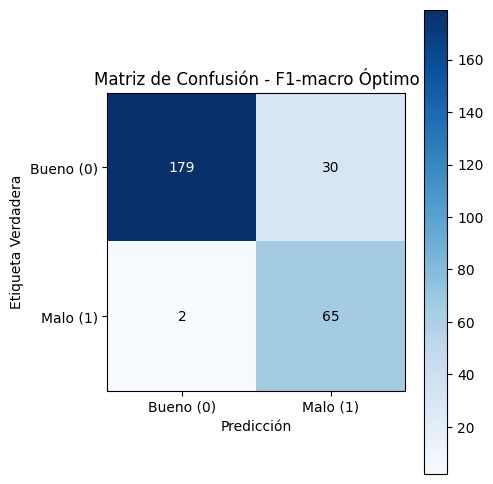

              precision    recall  f1-score   support

   Bueno (0)       0.99      0.86      0.92       209
    Malo (1)       0.68      0.97      0.80        67

    accuracy                           0.88       276
   macro avg       0.84      0.91      0.86       276
weighted avg       0.91      0.88      0.89       276



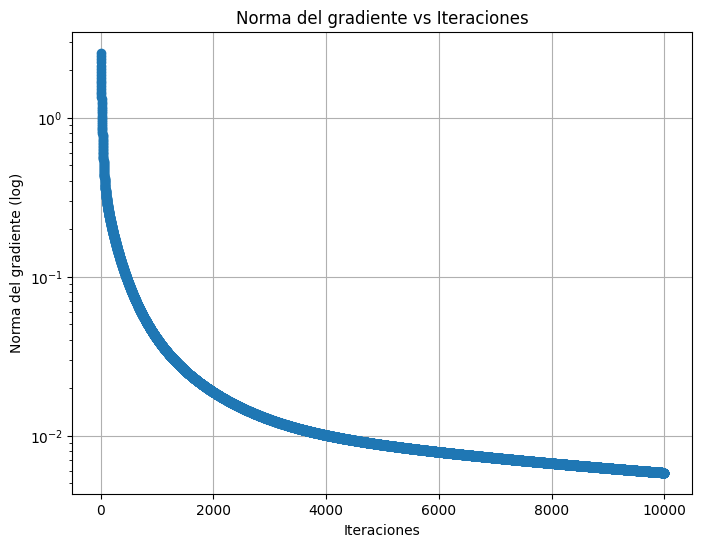

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE


df = pd.read_csv("Breast_Cancer.csv")
df.columns = df.columns.str.strip()
df['Status'] = df['Status'].map({'Alive':0, 'Dead':1})

categorical_cols = ['Marital Status', 'T Stage', 'N Stage', '6th Stage',
                    'differentiate', 'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status']
numerical_cols = ['Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']

df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

X_cat = pd.get_dummies(df[categorical_cols], drop_first=True)
X = pd.concat([X_cat, df[numerical_cols]], axis=1)
Y = df['Status'].values.reshape(-1,1)

scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X = X.values.astype(np.float64)
Y = Y.astype(np.float64)
X = np.hstack([X, np.ones((X.shape[0],1),dtype=np.float64)])  # bias

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)


sm = SMOTE(random_state=42)
X_train_smote, Y_train_smote = sm.fit_resample(X_train, Y_train.ravel())
X_train_smote = X_train_smote.astype(np.float64)
Y_train_smote = Y_train_smote.reshape(-1,1).astype(np.float64)


def safe_sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def calcular_gradiente_ponderado(theta, X, Y, peso_clase1=5.0):
    prob = safe_sigmoid(X @ theta)
    w = np.ones_like(Y)
    w[Y==1] = peso_clase1
    grad = (X.T @ ((prob - Y) * w)) / X.shape[0]
    return grad

def descenso_gradiente_ponderado(X, Y, theta, lr=0.01, tol=1e-4, max_iter=10000, peso_clase1=5.0):
    grad = calcular_gradiente_ponderado(theta, X, Y, peso_clase1)
    grad_norms = []
    iteracion = 0
    while iteracion < max_iter and np.linalg.norm(grad) > tol:
        theta -= lr * grad
        grad = calcular_gradiente_ponderado(theta, X, Y, peso_clase1)
        grad_norms.append(np.linalg.norm(grad))
        iteracion += 1
    return theta, grad_norms

theta_init = np.random.randn(X_train_smote.shape[1],1).astype(np.float64)*0.01
theta_opt, normas_grad = descenso_gradiente_ponderado(
    X_train_smote, Y_train_smote, theta_init, lr=0.01, tol=1e-4, max_iter=10000, peso_clase1=5.0
)


def clasificar_doble_umbral(prob, t0, t1):
    pred = np.full(prob.shape, -1)
    pred[prob <= t0] = 0
    pred[prob >= t1] = 1
    return pred

probabilidades = safe_sigmoid(X_test @ theta_opt)
mejor_f1_macro = 0
mejor_t0, mejor_t1 = 0.0, 1.0

for t0 in np.arange(0.0, 0.5, 0.05):
    for t1 in np.arange(0.5, 1.0, 0.05):
        pred = clasificar_doble_umbral(probabilidades, t0, t1)
        mask = pred != -1
        if np.sum(mask) == 0:
            continue
        pred_masked = pred[mask]
        if np.any(pred_masked == 0) and np.any(pred_masked == 1):
            f1_macro = f1_score(Y_test[mask], pred_masked, average='macro')
            if f1_macro > mejor_f1_macro:
                mejor_f1_macro = f1_macro
                mejor_t0, mejor_t1 = t0, t1

print(f"Mejor t0={mejor_t0:.2f}, t1={mejor_t1:.2f}, F1-macro={mejor_f1_macro:.4f}")


pred_final = clasificar_doble_umbral(probabilidades, mejor_t0, mejor_t1)
mask = pred_final != -1
print(f"Casos confiables: {np.sum(mask)} / {len(Y_test)}")
print(f"Casos inciertos: {np.sum(pred_final == -1)}")

if np.sum(mask) > 0:
    cm = confusion_matrix(Y_test[mask], pred_final[mask])
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión - F1-macro Óptimo")
    plt.colorbar()
    plt.xticks([0,1], ['Bueno (0)','Malo (1)'])
    plt.yticks([0,1], ['Bueno (0)','Malo (1)'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.ylabel("Etiqueta Verdadera")
    plt.xlabel("Predicción")
    plt.tight_layout()
    plt.show()

    print(classification_report(
        Y_test[mask],
        pred_final[mask],
        target_names=['Bueno (0)','Malo (1)']
    ))


plt.figure(figsize=(8,6))
plt.plot(range(1,len(normas_grad)+1),normas_grad,marker='o')
plt.yscale('log')
plt.xlabel("Iteraciones")
plt.ylabel("Norma del gradiente (log)")
plt.title("Norma del gradiente vs Iteraciones")
plt.grid(True)
plt.show()


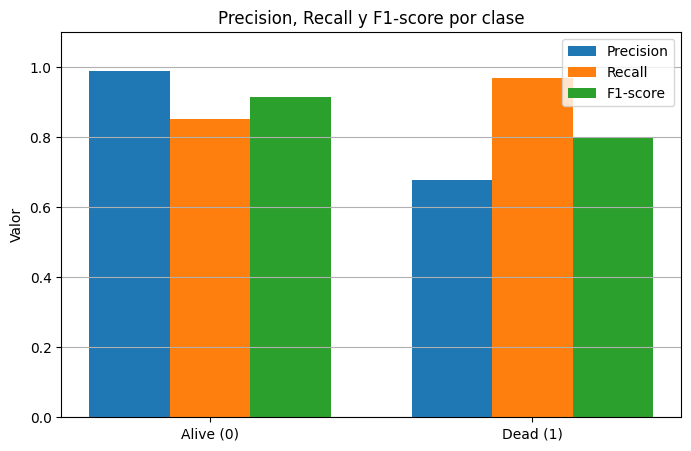

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(Y_test[mask], pred_final[mask])
clases = ['Alive (0)','Dead (1)']

x = np.arange(len(clases))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')

plt.xticks(x, clases)
plt.ylim(0,1.1)
plt.ylabel("Valor")
plt.title("Precision, Recall y F1-score por clase")
plt.legend()
plt.grid(axis='y')
plt.show()


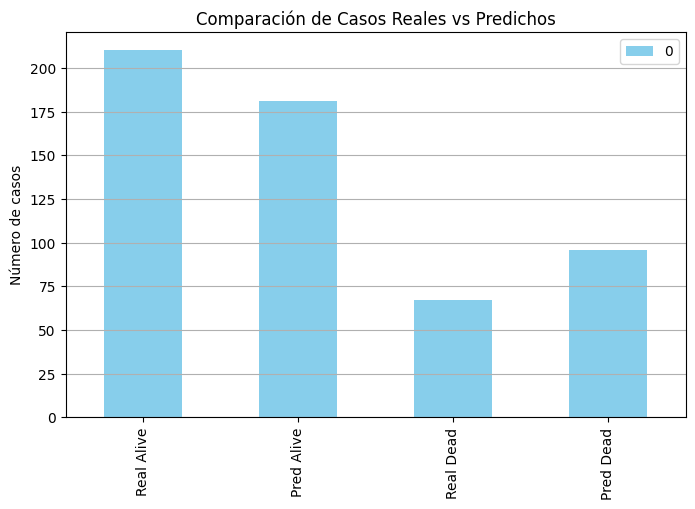

In [ ]:
import pandas as pd

df_comp = pd.DataFrame({
    'Real Alive': [np.sum((Y_test[mask]==0))],
    'Pred Alive': [np.sum((pred_final[mask]==0))],
    'Real Dead': [np.sum((Y_test[mask]==1))],
    'Pred Dead': [np.sum((pred_final[mask]==1))]
})

df_comp.T.plot(kind='bar', figsize=(8,5), color=['skyblue'])
plt.ylabel("Número de casos")
plt.title("Comparación de Casos Reales vs Predichos")
plt.grid(axis='y')
plt.show()
